### import

In [ ]:
import ast
import wfdb
import h5py

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.decomposition import PCA         
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.datasets import make_classification

from xgboost.sklearn import XGBClassifier
# import lightgbm as lgb  

### Read Data

In [ ]:
res = os.getcwd()
base_path = os.path.join(res)
base_path_ptb = os.path.join(res, 'ptb_xl_data') + '/'
base_path_shp = os.path.join(res, 'sph_data') + '/'

In [ ]:
df_ptb_origin = pd.read_csv(base_path_ptb + 'ptbxl_database.csv', encoding='utf-8',index_col='ecg_id')
df_sph_origin = pd.read_csv(base_path_shp + 'metadata.csv', encoding='utf-8', index_col='ECG_ID')

In [ ]:
df_ptb_lead1 = pd.read_csv(base_path + '/custom_file/ashton_ptb_lead1.csv', index_col=0)

df_sph_lead1 = pd.read_csv(base_path + '/custom_file/ashton_sph_lead1.csv', index_col=0)

### Ptb_xl의 심박수 데이터 lead1 추출 -> .csv 파일로만듬
 - 신호 및 의료 데이터에 대한 읽기 및 쓰기 기능을 제공하는 wfdb를 이용해서 데이터를 읽음.
 - 각 데이터는 PTBXL_DATABASE에 컬럼으로 만들어 져 있음. 100HZ와 500HZ중 500HZ사용. (테스트 데이터와 맞추기위해)
 - df_lead1.to_csv 로 저장해서 사용하기 편하게 만들어둠

In [ ]:
# #신호 데이터 읽기
# filenames = df_ptb_origin.filename_hr.tolist()    #filename_lr은 100Hz로 저장되어 있는 신호 데이터 파일 경로이고, filename_hr은 500Hz, 여기서는 500Hz만 사용

# df_lead1= pd.DataFrame()

# for ptb_index in tqdm(range(len(df_ptb_origin.index)), 'time'):
#     signal, meta = wfdb.rdsamp(base_path_ptb + filenames[ptb_index])
#     lead1 = signal[:, 0]
#     df_lead1 = pd.concat([df_lead1, pd.DataFrame(lead1).T], axis=0)
# df_lead1.index = df_ptb_origin.index[:]

# df_lead1.to_csv(base_path + r'\custom_file\ashton_ptb_lead1.csv', encoding='UTF-8')

### shp의 심박수 데이터 lead1 추출 -> .csv 파일로만듬

In [ ]:
# filenames = sorted(glob(base_path + r"sph_data\records_sph\*.h5"))

# df_sph_origin['filename'] = filenames

# df_lead1_sph = pd.DataFrame()

# for shp_index in tqdm(range(len(df_sph_origin.index)), 'time'):
# # for shp_index in tqdm(range(0, 3), desc='time'):
#     filename = df_sph_origin.filename.tolist()[shp_index]

#     with h5py.File(filename, 'r') as f:
#         signal = f['ecg'][:]
#     lead1 = signal[0, :]

#     if lead1.shape[0] == 5000:
#         lead1_df = pd.DataFrame(lead1)
#     # 데이터의 길이가 5000보다 큰 경우, 연속적인 5000개의 데이터를 랜덤하게 선택
#     else:
#         start_idx = np.random.randint(0, lead1.shape[0] - 4999)  # 마지막 5000개를 포함할 수 있도록 인덱스 설정
#         lead1_df = pd.DataFrame(lead1[start_idx:start_idx+5000])

#     df_lead1_sph = pd.concat([df_lead1_sph, pd.DataFrame(lead1_df).T], axis=0, ignore_index=True)

# df_lead1_sph.index = df_sph_origin.index

# df_lead1_sph.to_csv(base_path + r'\custom_file\ashton_sph_lead1.csv', encoding='UTF-8')

### PTB_xl, SHP 데이터 라벨링

In [ ]:
#PTB 라벨링

#scp_codes 에서 AFIB에 해당하는 것에 대해서 라벨링
df_ptb_origin.scp_codes = df_ptb_origin.scp_codes.apply(lambda x: ast.literal_eval(x))
df_ptb_origin.scp_codes = df_ptb_origin.scp_codes.apply(lambda x: list(x.keys()))
df_ptb_origin['label'] = df_ptb_origin.scp_codes.apply(lambda arr: 1 if 'AFIB' in arr else 0)

print('df_ptb_origin : ',df_ptb_origin.label.value_counts())
print('-'*15)

#SHP 라벨링

# df_sph_origin['label'] = df_sph_origin['AHA_Code'].apply(lambda x: 1 if '50' in str(x) else 0) - 기존에 잘못된
# 'AHA_Code' 컬럼의 각 값에 대해 '50'이 포함되어 있는지 확인하고, 'label' 컬럼 생성
def check_contains_50(code):
    # 공백을 없애고, ';' 또는 '+'로 분리
    numbers = code.replace(' ', '').replace('+', ';').split(';')
    # '50'이 포함되어 있는지 확인
    return '50' in numbers
# 'label' 컬럼 생성
df_sph_origin['label'] = df_sph_origin['AHA_Code'].apply(check_contains_50).astype(int)


print('df_sph_origin : ',df_sph_origin.label.value_counts())

df_ptb_origin :  label
0    20285
1     1514
Name: count, dtype: int64
---------------
df_sph_origin :  label
0    25095
1      675
Name: count, dtype: int64


### age, sex, label 컬럼과 심박수 데이터 합치기

In [ ]:
df_ptb = pd.concat([df_ptb_origin[['age', 'sex', 'label']], df_ptb_lead1], axis=1)

df_sph_lead1.index = df_sph_origin.index
df_sph = pd.concat([df_sph_origin[['Age', 'Sex', 'label']], df_sph_lead1], axis=1)

### 'age', 'sex' 사용 여부에 따른 train, val, test 
- input 요소 있음.
  - 심박수 데이터만 사용할려면 : N
  - age, sex데이터를 함께 사용하려면 : Y
  
(답변시 대문자 소문자 상관없음)

### 이상치 데이터 제거

In [ ]:
outlier_list=[  103,   143,   158,   172,   750,   812,  1009,  1077,  1140,
        1606,  2022,  2031,  2304,  2676,  2767,  2814,  2837,  3055,
        3169,  3237,  3540,  3695,  3837,  3924,  3974,  4099,  4421,
        4588,  4748,  4787,  5123,  5133,  5141,  5167,  5337,  5482,
        5506,  5515,  5562,  5566,  5656,  5658,  5772,  5983,  6260,
        6278,  6319,  6503,  6521,  6577,  6678,  6746,  6899,  7066,
        7293,  7374,  7470,  7533,  7644,  7740,  8107,  8117,  8264,
        8503,  8641,  8706,  8724,  8773,  8913,  8926,  9168,  9451,
        9572,  9579,  9606,  9632,  9914,  9934, 10228, 10574, 10789,
       10952, 11096, 11123, 11160, 11296, 11343, 11397, 12195, 12343,
       12466, 12470, 12731, 12762, 12870, 13071, 13370, 13617, 13764,
       13873, 14226, 14362, 14451, 14543, 14646, 14726, 14823, 15055,
       15127, 15153, 15328, 15362, 15614, 15991, 16268, 16519, 16811,
       16953, 17106, 17205, 17392, 17413]
outlier_list =reversed(outlier_list)

In [ ]:
df_ptb_outlier_drop = df_ptb.copy()  
for i in outlier_list:
    df_ptb_outlier_drop = df_ptb_outlier_drop.drop(df_ptb_outlier_drop.index[i])


In [ ]:
X = df_ptb_outlier_drop.drop(['age', 'sex', 'label'], axis=1)
y = df_ptb_outlier_drop['label']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_sph_test = df_sph.drop(['Age', 'Sex', 'label'], axis=1)
y_sph_test = df_sph['label']


### 정규화

In [ ]:
from sklearn.preprocessing import Normalizer     

In [ ]:
# scaler_std = StandardScaler()
scaler_std = Normalizer()  #최종 결과물이 75%가나옴
# scaler_std = MinMaxScaler()
# scaler_std = RobustScaler()
X_train = scaler_std.fit_transform(X_train)
X_val = scaler_std.transform(X_val)
X_test = scaler_std.transform(X_test)
X_sph_test = scaler_std.transform(X_sph_test)

In [ ]:
from imblearn.combine import *

In [ ]:
print(X_train.shape)
print(y_train.shape)

(17341, 5000)
(17341,)


### resampling

In [ ]:
# X_samp, y_samp = SMOTETomek(random_state=42).fit_resample(X_train, y_train)

# print(X_samp.shape)
# print(y_samp.shape)

# X_train = X_samp
# y_train = y_samp

In [ ]:
from imblearn.under_sampling import TomekLinks

In [ ]:

# X_samp, y_samp = SMOTETomek(random_state=42).fit_resample(X_train, y_train)

# print(X_samp.shape)
# print(y_samp.shape)

# X_train = X_samp
# y_train = y_samp

(32276, 5000)
(32276,)


In [ ]:
# XGBoost - 최적의 하이퍼파라미터: {'n_estimators': 199, 'max_depth': 10, 'learning_rate': 0.09970153772587603, 'min_child_weight': 1, 
#'subsample': 0.6045342725237628, 'reg_lambda': 0.045745215390969}
# RandomForest - 최적의 하이퍼파라미터: {'n_estimators': 181, 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2}
# CatBoost - 최적의 하이퍼파라미터: {'n_estimators': 194, 'depth': 10, 'learning_rate': 0.03680446425045185}
# LGBM - 최적의 하이퍼파라미터: {'n_estimators': 195, 'max_depth': 10, 'learning_rate': 0.0843700037939962}

### optuna

In [ ]:
# import optuna
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier



# # XGBoost 모델에 대한 objective 함수 정의

# def xgb_objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 200),
#         'max_depth': trial.suggest_int('max_depth', 4, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 1.0),
#         # Add other XGBoost hyperparameters...

#         # Fixing random parameters
#         'random_state': 42,
#         'n_jobs': -1,
#     }

#     model = XGBClassifier(**params)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_val)
#     accuracy = accuracy_score(y_val, y_pred)
#     return accuracy

# # RandomForest 모델에 대한 objective 함수 정의
# def rf_objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 200),
#         'max_depth': trial.suggest_int('max_depth', 4, 10),
#         'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [8, 12, 18]),
#         'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5, 10]),

#         'random_state': 42,
 
#     }

#     model = RandomForestClassifier(**params)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_val)
#     accuracy = accuracy_score(y_val, y_pred)
#     return accuracy

# # CatBoost 모델에 대한 objective 함수 정의


# def catboost_objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 200),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'random_state': 42,
#     }


#     model = CatBoostClassifier(**params)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_val)
#     accuracy = accuracy_score(y_val, y_pred)
#     return accuracy

# # LGBM 모델에 대한 objective 함수 정의
# def lgbm_objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 200),
#         'max_depth': trial.suggest_int('max_depth', 4, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
#         'random_state': 42
#     }

#     model = LGBMClassifier(**params)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_val)
#     accuracy = accuracy_score(y_val, y_pred)
#     return accuracy

# # Optuna 스터디 생성 및 실행 (XGBoost)
# xgb_study = optuna.create_study(direction='maximize')
# xgb_study.optimize(xgb_objective, n_trials=30)
# best_params_xgb = xgb_study.best_params
# print("XGBoost - 최적의 하이퍼파라미터:", best_params_xgb)

# # Optuna 스터디 생성 및 실행 (RandomForest)
# rf_study = optuna.create_study(direction='maximize')
# rf_study.optimize(rf_objective, n_trials=30)
# best_params_rf = rf_study.best_params
# print("RandomForest - 최적의 하이퍼파라미터:", best_params_rf)

# # Optuna 스터디 생성 및 실행 (CatBoost)
# catboost_study = optuna.create_study(direction='maximize')
# catboost_study.optimize(catboost_objective, n_trials=30)
# best_params_catboost = catboost_study.best_params
# print("CatBoost - 최적의 하이퍼파라미터:", best_params_catboost)

# # Optuna 스터디 생성 및 실행 (LGBM)
# lgbm_study = optuna.create_study(direction='maximize')
# lgbm_study.optimize(lgbm_objective, n_trials=30)
# best_params_lgbm = lgbm_study.best_params
# print("LGBM - 최적의 하이퍼파라미터:", best_params_lgbm)


In [ ]:
# print("XGBoost - 최적의 하이퍼파라미터:", best_params_xgb)
# print("RandomForest - 최적의 하이퍼파라미터:", best_params_rf)
# print("CatBoost - 최적의 하이퍼파라미터:", best_params_catboost)
# print("LGBM - 최적의 하이퍼파라미터:", best_params_lgbm)


# XGBoost - 최적의 하이퍼파라미터: {'n_estimators': 199, 'max_depth': 10, 'learning_rate': 0.09970153772587603, 'min_child_weight': 1, 'subsample': 0.6045342725237628, 'reg_lambda': 0.045745215390969}
# RandomForest - 최적의 하이퍼파라미터: {'n_estimators': 181, 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2}
# CatBoost - 최적의 하이퍼파라미터: {'n_estimators': 194, 'depth': 10, 'learning_rate': 0.03680446425045185}
# LGBM - 최적의 하이퍼파라미터: {'n_estimators': 195, 'max_depth': 10, 'learning_rate': 0.0843700037939962}


In [ ]:
# # 최적의 XGBoost 모델 생성 및 성능 평가
# best_xgb_model = XGBClassifier(**best_params_xgb)
# best_xgb_model.fit(X_train, y_train)

# # AUROC 계산
# y_val_prob_best_xgb = best_xgb_model.predict_proba(X_val)[:, 1]
# auroc_best_xgb = roc_auc_score(y_val, y_val_prob_best_xgb)
# print("XGBoost - AUROC:", auroc_best_xgb)

# # Confusion Matrix 출력
# y_val_pred_best_xgb = best_xgb_model.predict(X_val)
# conf_matrix_best_xgb = confusion_matrix(y_val, y_val_pred_best_xgb)
# print("XGBoost - Confusion Matrix:")
# print(conf_matrix_best_xgb)

# # XGBoost - AUROC: 0.6830385432433586
# # XGBoost - Confusion Matrix:
# # [[1962   55]
# #  [ 136   15]]

In [ ]:
# # 최적의 RandomForest 모델 생성 및 성능 평가
# best_rf_model = RandomForestClassifier(**best_params_rf)
# best_rf_model.fit(X_train, y_train)

# # AUROC 계산
# y_val_prob_best_rf = best_rf_model.predict_proba(X_val)[:, 1]
# auroc_best_rf = roc_auc_score(y_val, y_val_prob_best_rf)
# print("RandomForest - AUROC:", auroc_best_rf)

# # Confusion Matrix 출력
# y_val_pred_best_rf = best_rf_model.predict(X_val)
# conf_matrix_best_rf = confusion_matrix(y_val, y_val_pred_best_rf)
# print("RandomForest - Confusion Matrix:")
# print(conf_matrix_best_rf)

# # RandomForest - AUROC: 0.714864052901332
# # RandomForest - Confusion Matrix:
# # [[1881  136]
# #  [ 121   30]]

In [ ]:
# # 최적의 CatBoost 모델 생성 및 성능 평가
# best_catboost_model = CatBoostClassifier(**best_params_catboost)
# best_catboost_model.fit(X_train, y_train, verbose=False)

# # AUROC 계산
# y_val_prob_best_catboost = best_catboost_model.predict_proba(X_val)[:, 1]
# auroc_best_catboost = roc_auc_score(y_val, y_val_prob_best_catboost)
# print("CatBoost - AUROC:", auroc_best_catboost)

# # Confusion Matrix 출력
# y_val_pred_best_catboost = best_catboost_model.predict(X_val)
# conf_matrix_best_catboost = confusion_matrix(y_val, y_val_pred_best_catboost)
# print("CatBoost - Confusion Matrix:")
# print(conf_matrix_best_catboost)

# # CatBoost - AUROC: 0.6755984725856709
# # CatBoost - Confusion Matrix:
# # [[1822  195]
# #  [ 112   39]]

In [ ]:
# # 최적의 LGBMClassifier 모델 생성 및 성능 평가
# best_lgbm_model = LGBMClassifier(**best_params_lgbm)
# best_lgbm_model.fit(X_train, y_train)

# # AUROC 계산
# y_val_prob_best_lgbm = best_lgbm_model.predict_proba(X_val)[:, 1]
# auroc_best_lgbm = roc_auc_score(y_val, y_val_prob_best_lgbm)
# print("LGBMClassifier - AUROC:", auroc_best_lgbm)

# # Confusion Matrix 출력
# y_val_pred_best_lgbm = best_lgbm_model.predict(X_val)
# conf_matrix_best_lgbm = confusion_matrix(y_val, y_val_pred_best_lgbm)
# print("LGBMClassifier - Confusion Matrix:")
# print(conf_matrix_best_lgbm)

# # LGBMClassifier - AUROC: 0.669790226780971
# # [LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
# # LGBMClassifier - Confusion Matrix:
# # [[1904  113]
# #  [ 126   25]]

### 모델

In [ ]:
# xgb = XGBClassifier(n_estimators=197,
#                     max_depth=10,
#                     # colsample_bynode=0.5,
#                     # colsample_bytree=0.5,
#                     # colsample_bylevel=0.5,
#                     # reg_lambda=1,
#                     learning_rate=0.08916601462588336,
#                     random_state=42,
#                     n_jobs=-1)

# model = xgb

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# RandomForest - 최적의 하이퍼파라미터: {'n_estimators': 119, 'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 10, 'bootstrap': True, 'min_impurity_decrease': 0.18870724161519983, 'criterion': 'gini'}

In [ ]:
# RandomForest - 최적의 하이퍼파라미터: {'n_estimators': 181, 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2}

In [ ]:
params = {
        'n_estimators': 181,
        'max_depth': 10,
        'min_samples_leaf': 8,
        'min_samples_split': 2,

        'random_state': 42,
 
    }

model = RandomForestClassifier(**params)

In [ ]:
# params = {
#         'n_estimators': 181,
#         'max_depth': 10,
#         'min_samples_leaf': 8,
#         'min_samples_split': 2,

#         'random_state': 42,
 
#     }

# model = RandomForestClassifier(**params)

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=8, n_estimators=181,
                       random_state=42)

### Ptb_xl의 Val 진행( 10% 데이터)

In [ ]:
# 모델로 예측 수행
y_val_pred = model.predict(X_val)

In [ ]:
cross_entropy = log_loss(y_val, y_val_pred, labels=[0, 1])
print(f'Cross-Entropy: {cross_entropy}')

Cross-Entropy: 4.056573536413554


In [ ]:


# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

# True Positive, False Positive, False Negative, True Negative
tp, fp, fn, tn = conf_matrix.ravel()

# Sensitivity (Recall)
sensitivity = tp / (tp + fn)
print(f"Sensitivity (Recall): {sensitivity}")

# Specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")

# Precision
precision = precision_score(y_val, y_val_pred)
print(f"Precision: {precision}")

# F1 Score
f1 = f1_score(y_val, y_val_pred)
print(f"F1 Score: {f1}")

# AUROC
y_prob = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUROC: {roc_auc}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

Confusion Matrix:
[[1891  126]
 [ 118   33]]
Sensitivity (Recall): 0.9412643106022897
Specificity: 0.20754716981132076
Precision: 0.20754716981132076
F1 Score: 0.21290322580645163


AUROC: 0.7009557831281787
Precision-Recall AUC: 0.1413399078755035


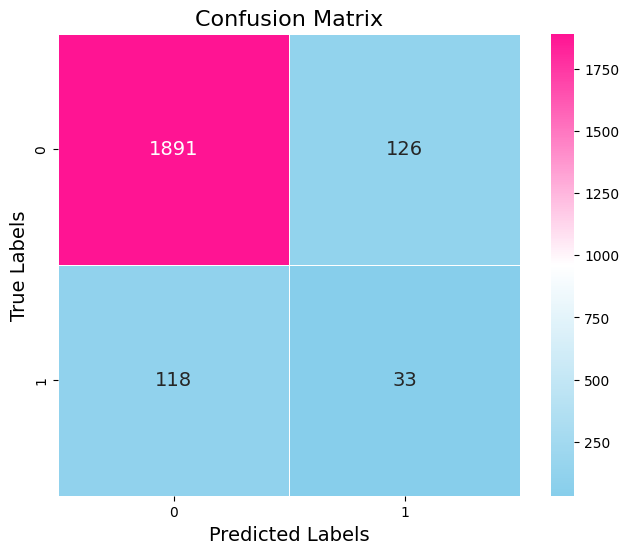

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# 예측과 정답을 기반으로 Confusion Matrix 계산
conf_matrix = confusion_matrix(y_val, y_val_pred)

# 사용자 정의 그라데이션 컬러맵 생성
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['skyblue', 'white', '#FF1493'], N=256)

# Matplotlib을 사용하여 Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, 
            annot_kws={"size": 14}, linewidths=.5, square=True)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

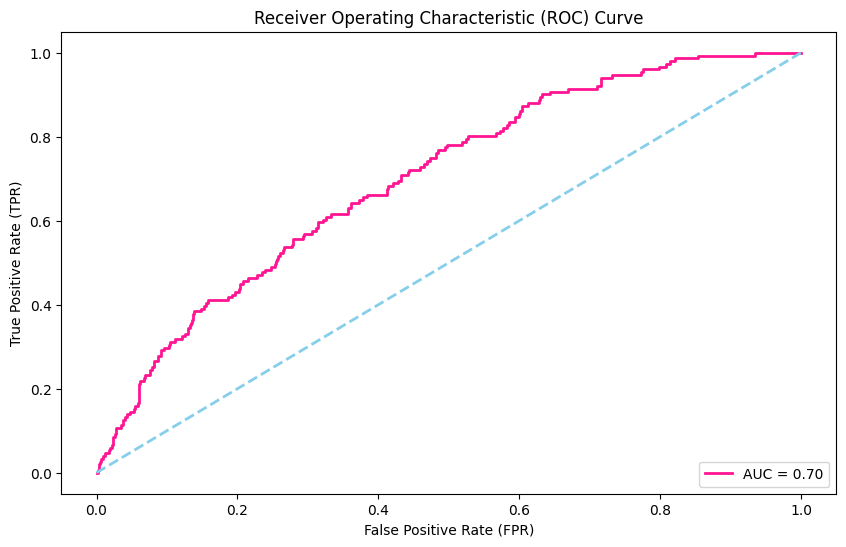

In [ ]:

# 예측 확률 얻기
y_val_pred = model.predict_proba(X_val)[:, 1]

# FPR, TPR 계산
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

# AUC 계산
roc_auc = auc(fpr, tpr)

# AUROC 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='#FF1493', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='skyblue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Ptb_xl의 test 진행( 10% 데이터)

In [ ]:
# 모델로 예측 수행
y_test_pred = model.predict(X_test)

In [ ]:
cross_entropy = log_loss(y_test, y_test_pred, labels=[0, 1])
print(f'Cross-Entropy: {cross_entropy}')

Cross-Entropy: 4.638459084669597


In [ ]:


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# True Positive, False Positive, False Negative, True Negative
tp, fp, fn, tn = conf_matrix.ravel()

# Sensitivity (Recall)
sensitivity = tp / (tp + fn)
print(f"Sensitivity (Recall): {sensitivity}")

# Specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")

# Precision
precision = precision_score(y_test, y_test_pred)
print(f"Precision: {precision}")

# F1 Score
f1 = f1_score(y_test, y_test_pred)
print(f"F1 Score: {f1}")

# AUROC
y_test_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)
print(f"AUROC: {roc_auc}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

Confusion Matrix:
[[1869  149]
 [ 130   20]]
Sensitivity (Recall): 0.9349674837418709
Specificity: 0.11834319526627218
Precision: 0.11834319526627218
F1 Score: 0.12539184952978052
AUROC: 0.6384836471754212
Precision-Recall AUC: 0.1063489564842163


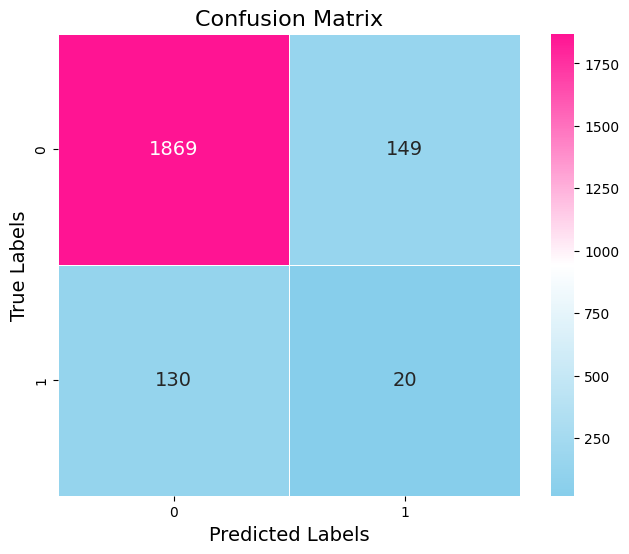

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# 예측과 정답을 기반으로 Confusion Matrix 계산
conf_matrix = confusion_matrix(y_test, y_test_pred)

# 사용자 정의 그라데이션 컬러맵 생성
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['skyblue', 'white', '#FF1493'], N=256)

# Matplotlib을 사용하여 Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, 
            annot_kws={"size": 14}, linewidths=.5, square=True)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

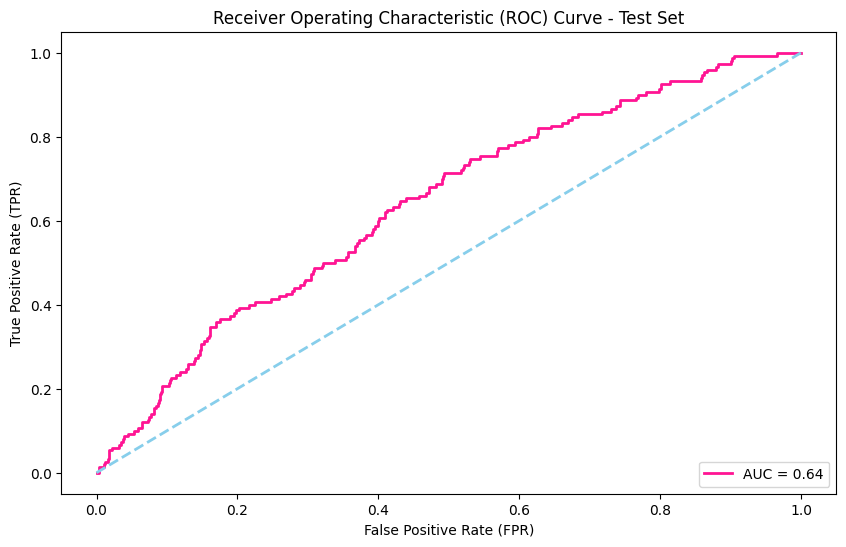

In [ ]:
# 예측 확률 얻기
y_test_pred = model.predict_proba(X_test)[:, 1]

# FPR, TPR 계산
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)

# AUC 계산
roc_auc_test = auc(fpr_test, tpr_test)

# AUROC 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, color='#FF1493', lw=2, label=f'AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], color='skyblue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

### SPH 데이터 테스트 진행

In [ ]:
# 모델로 예측 수행
y_sph_pred = model.predict(X_sph_test)

In [ ]:
cross_entropy = log_loss(y_sph_test, y_sph_pred, labels=[0, 1])
print(f'Cross-Entropy: {cross_entropy}')

Cross-Entropy: 3.34561190945938


In [ ]:


# Confusion Matrix
conf_matrix = confusion_matrix(y_sph_test, y_sph_pred)
print("Confusion Matrix:")
print(conf_matrix)

# True Positive, False Positive, False Negative, True Negative
tp, fp, fn, tn = conf_matrix.ravel()

# Sensitivity (Recall)
sensitivity = tp / (tp + fn)
print(f"Sensitivity (Recall): {sensitivity}")

# Specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")

# Precision
precision = precision_score(y_sph_test, y_sph_pred)
print(f"Precision: {precision}")

# F1 Score
f1 = f1_score(y_sph_test, y_sph_pred)
print(f"F1 Score: {f1}")

# AUROC
y_sph_prob = model.predict_proba(X_sph_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_sph_test, y_sph_prob)
roc_auc = auc(fpr, tpr)
print(f"AUROC: {roc_auc}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_sph_test, y_sph_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

Confusion Matrix:
[[23270  1825]
 [  567   108]]
Sensitivity (Recall): 0.9762134496790703
Specificity: 0.05587170201758924
Precision: 0.05587170201758924
F1 Score: 0.08282208588957055


AUROC: 0.7004812232036779
Precision-Recall AUC: 0.04952363827576806


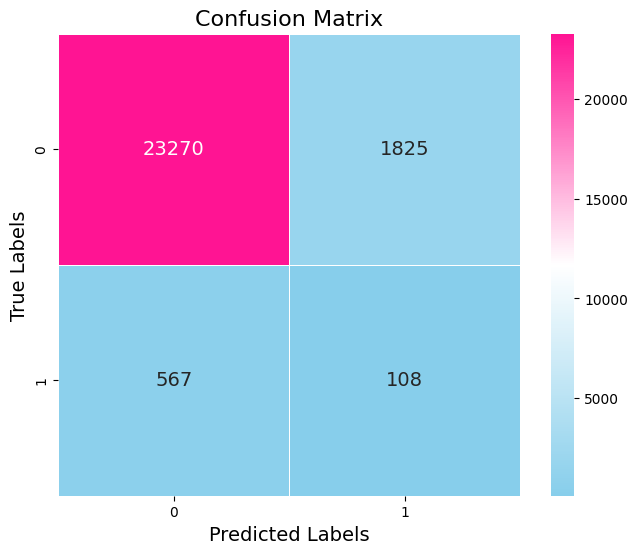

In [ ]:
# 예측과 정답을 기반으로 Confusion Matrix 계산
conf_matrix = confusion_matrix(y_sph_test, y_sph_pred)

# 사용자 정의 그라데이션 컬러맵 생성
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['skyblue', 'white', '#FF1493'], N=256)

# Matplotlib을 사용하여 Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, 
            annot_kws={"size": 14}, linewidths=.5, square=True)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

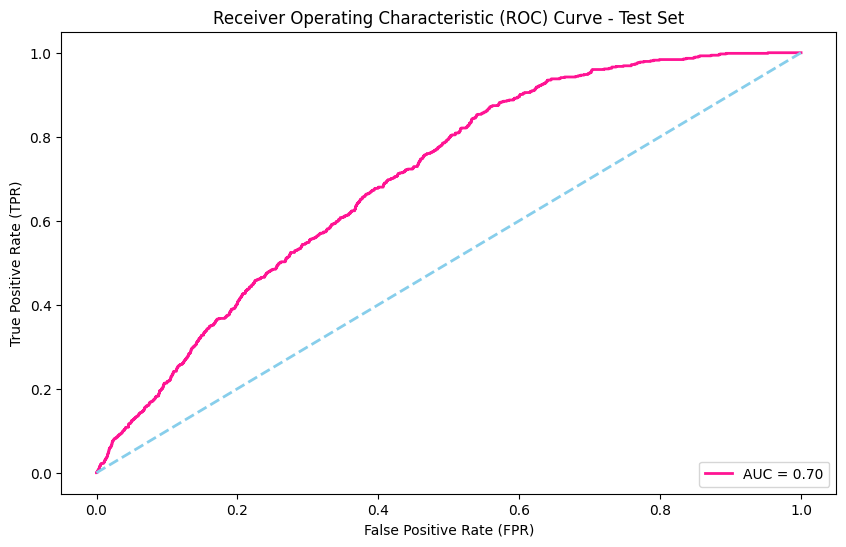

In [ ]:
# 예측 확률 얻기
y_test_pred = model.predict_proba(X_sph_test)[:, 1]

# FPR, TPR 계산
fpr_test, tpr_test, thresholds_test = roc_curve(y_sph_test, y_test_pred)

# AUC 계산
roc_auc_test = auc(fpr_test, tpr_test)

# AUROC 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, color='#FF1493', lw=2, label=f'AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], color='skyblue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()